In [9]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

import ESC 
from tensorflow.keras.regularizers import l2

## Load Data
Scaling directly the audio data to range 0-1 makes no sense because it will affect the melspectrogram conversion, so we have to:
1. Load data.
2. Compute spectrogram segments.
3. Merge all folds segments and find min-max in order to scale consistently across different folds.
4. Split the datasets again.

In [2]:
PATH = 'audio'
raw_files, cvs, labels = ESC.Load_RAW(PATH)

# Split the different folds
f1, f2, f3, f4, f5 = ESC.Split_Folds(raw_files, cvs, labels, verbose=True)

100%|██████████| 2000/2000 [00:00<00:00, 666927.02it/s]

Folds size: 400 - 400 - 400 - 400 - 400
Folds sample shape:  2
Folds sample data shape:  (110250,)
Folds sample label type:  (50,)


In [3]:
af4, alf4 = ESC.Split_Data_Label(f4)

In [4]:
# Load augmented
af1, alf1 = ESC.Load_Augmented(name='af1', path='Augmented_2/')
af2, alf2 = ESC.Load_Augmented(name='af2', path='Augmented_2/')
af3, alf3 = ESC.Load_Augmented(name='af3', path='Augmented_2/')
#af4, alf4 = ESC.Load_Augmented(name='af4', path='Augmented_2/')
#af5, alf5 = ESC.Load_Augmented(name='af5', path='Augmented_2/')

In [5]:
# Compute log-melspec and deltas
f1p, lf1p = ESC.Preprocessing(af1, alf1)
f2p, lf2p = ESC.Preprocessing(af2, alf2)
f3p, lf3p = ESC.Preprocessing(af3, alf3)
f4p, lf4p = ESC.Preprocessing(af4, alf4)
#f5p, lf5p = ESC.Preprocessing(af5, alf5)

100%|██████████| 400/400 [00:02<00:00, 149.14it/s]


In [6]:
# Scale the data in each fold to 0 1
f1p = np.interp(f1p, (f1p.min(), f1p.max()), (0, +1))
f2p = np.interp(f2p, (f2p.min(), f2p.max()), (0, +1))
f3p = np.interp(f3p, (f3p.min(), f3p.max()), (0, +1))
f4p = np.interp(f4p, (f4p.min(), f4p.max()), (0, +1))
#f5p = np.interp(f5p, (f5p.min(), f5p.max()), (0, +1))


# Define Network and Training

In [10]:
def BackBoneNet(input_shape):
    
    X_input = tf.keras.Input(input_shape)
    
    # First branch with basic 3x3 kernel
    model = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', name='b1_conv0')(X_input)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    # Second branch with two stacked 3x3 kernel should equal to a single 9x9 from the original input
    branch_2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', name='b2_conv0')(X_input)
    branch_2 = tf.keras.layers.BatchNormalization(axis=3)(branch_2)
    branch_2 = tf.keras.layers.Activation('relu')(branch_2)
    branch_2 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', name='b2_conv1')(branch_2)
    branch_2 = tf.keras.layers.BatchNormalization(axis=3)(branch_2)
    branch_2 = tf.keras.layers.Activation('relu')(branch_2)

    
    # Third branch with stacked dilated kernel
    branch_3 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), dilation_rate=(2, 2), padding='same', name='b3_conv0')(X_input)
    branch_3 = tf.keras.layers.BatchNormalization(axis=3)(branch_3)
    branch_3 = tf.keras.layers.Activation('relu')(branch_3)

    # Fifth branch with stacked dilated kernel
    branch_4 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), dilation_rate=(4, 4), padding='same', name='b5_conv0')(X_input)
    branch_4 = tf.keras.layers.BatchNormalization(axis=3)(branch_4)
    branch_4 = tf.keras.layers.Activation('relu')(branch_4)
    
    sdc = tf.concat(values=[branch_3, branch_4], axis=3, name='stacked_dilated_conv')
    sdc = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', name='sdc_conv')(sdc)
    
    
    # Contanetare all the parallel branches
    X = tf.concat(values=[model, branch_2, sdc], axis=3, name='test')
    

    ##### MAIN PATH ##### 
    # First component of main path (3 lines)
    main_path = tf.keras.layers.Conv2D(128, kernel_size=1, strides=2, padding='valid', kernel_initializer='glorot_uniform', name='main_path_' + '1st')(X)
    main_path = tf.keras.layers.BatchNormalization(axis=3)(main_path)
    main_path = tf.keras.layers.Activation('relu')(main_path)
    
    # Second component of main path (3 lines)
    main_path = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_uniform', name='main_path_' + '2nd')(main_path)
    main_path = tf.keras.layers.BatchNormalization(axis=3)(main_path)
    main_path = tf.keras.layers.Activation('relu')(main_path)

    # Third component of main path (2 lines)
    main_path = tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', kernel_initializer='glorot_uniform', name='main_path_' + '3rd')(main_path)
    main_path = tf.keras.layers.BatchNormalization(axis=3)(main_path)

    ##### SHORTCUT PATH #### (2 lines)
    X_shortcut = tf.keras.layers.Conv2D(256, kernel_size=1, strides=2, padding='valid', kernel_initializer='glorot_uniform', name='shortcut')(X)
    X_shortcut = tf.keras.layers.BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X_final = tf.keras.layers.Add()([X_shortcut, main_path])
    X_final = tf.keras.layers.BatchNormalization(axis=3)(X_final)
    X_final = tf.keras.layers.Activation('relu')(X_final)
    
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X_final = tf.keras.layers.Add()([X_shortcut, main_path])
    X_final = tf.keras.layers.BatchNormalization(axis=3)(X_final)
    X_final = tf.keras.layers.Activation('relu')(X_final)
    
    
    
    ### MORE RES-BLOCK FOR DEPTH #####
    main_path_2 = tf.keras.layers.Conv2D(128, kernel_size=1, strides=2, padding='valid', kernel_initializer='glorot_uniform', name='main_path_2' + '1st')(X_final)
    main_path_2 = tf.keras.layers.BatchNormalization(axis=3)(main_path_2)
    main_path_2 = tf.keras.layers.Activation('relu')(main_path_2)
    
    # Second component of main path (3 lines)
    main_path_2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_uniform', name='main_path_2' + '2nd')(main_path_2)
    main_path_2 = tf.keras.layers.BatchNormalization(axis=3)(main_path_2)
    main_path_2 = tf.keras.layers.Activation('relu')(main_path_2)

    # Third component of main path (2 lines)
    main_path_2 = tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', kernel_initializer='glorot_uniform', name='main_path_2' + '3rd')(main_path_2)
    main_path_2 = tf.keras.layers.BatchNormalization(axis=3)(main_path_2)

    ##### SHORTCUT PATH #### (2 lines)
    X_shortcut_2 = tf.keras.layers.Conv2D(256, kernel_size=1, strides=2, padding='valid', kernel_initializer='glorot_uniform', name='shortcut_2')(X_final)
    X_shortcut_2 = tf.keras.layers.BatchNormalization(axis=3)(X_shortcut_2)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X_final_2 = tf.keras.layers.Add()([X_shortcut_2, main_path_2])
    X_final_2 = tf.keras.layers.BatchNormalization(axis=3)(X_final_2)
    X_final_2 = tf.keras.layers.Activation('relu')(X_final_2)
    
    
    
    
    # Flatten and fully connect the features
    model = tf.keras.layers.Flatten()(X_final_2)
    model = tf.keras.layers.Dense(5000, activation='relu', kernel_regularizer=l2(0.001), name='fc0')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    model = tf.keras.layers.Dense(1000, activation='relu', kernel_regularizer=l2(0.001), name='fc1')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=model, name='DevNet')
    
    return model


def ESC50Classifier(input_shape=1000):
    
    X_input = tf.keras.Input(input_shape)
    
    # Feature reduction
    model = tf.keras.layers.Dense(500, activation='relu', name='c_fc1')(X_input)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Output classifier layer
    model = tf.keras.layers.Dense(50, activation='softmax', name='out')(model)
    
    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=model, name='ESC50_Classifier')
    
    return model



def ESC10Classifier(input_shape=1000):
    
    X_input = tf.keras.Input(input_shape)
    
    # Feature reduction
    model = tf.keras.layers.Dense(500, activation='relu', name='c_fc1')(X_input)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Output classifier layer
    model = tf.keras.layers.Dense(10, activation='softmax', name='out')(model)
    
    # Create model
    model = tf.keras.Model(inputs=X_input, outputs=model, name='ESC10_Classifier')
    
    return model



def Docking(back_bone, classifier):
    
    model = tf.keras.Model(inputs=back_bone.input, outputs=classifier(back_bone.output), name='Merged')

    return model

In [11]:
BackboneNet = BackBoneNet([60, 41, 2])
Classifier50 = ESC50Classifier([1000])

MFNet = Docking(BackboneNet, Classifier50)

print(MFNet.summary())
opt = tf.keras.optimizers.Adam(lr=0.00001)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
MFNet.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])

Model: "Merged"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 41, 2)]  0                                            
__________________________________________________________________________________________________
b2_conv0 (Conv2D)               (None, 60, 41, 32)   608         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 60, 41, 32)   128         b2_conv0[0][0]                   
__________________________________________________________________________________________________
b3_conv0 (Conv2D)               (None, 60, 41, 32)   1632        input_2[0][0]                    
_____________________________________________________________________________________________

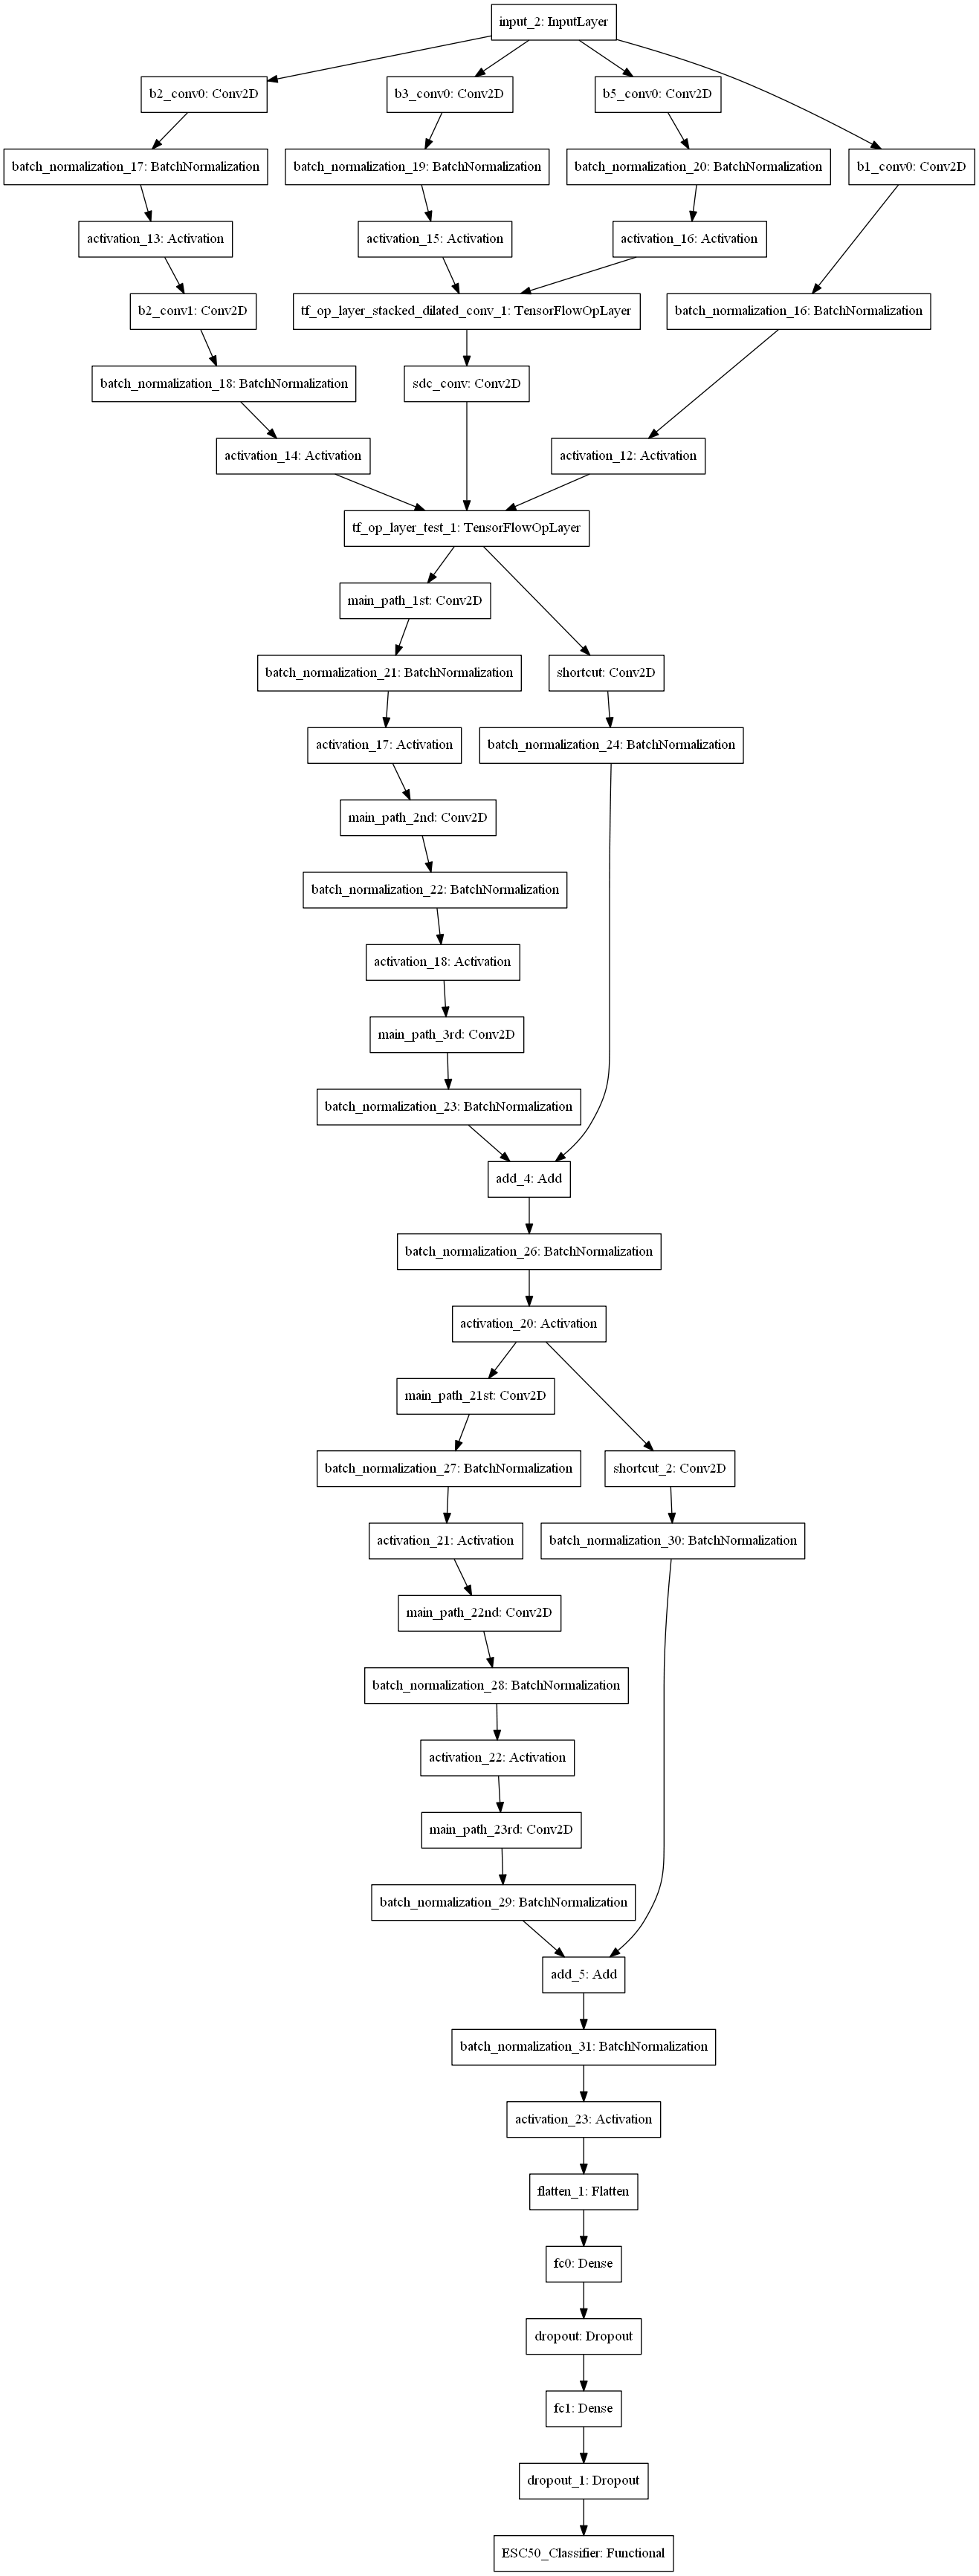

In [12]:
plot_model(MFNet)

In [13]:
training_dataset = ESC.CreateTrainingSet(f1p, f2p, f3p, lf1p, lf2p, lf3p, batch_size=128)
validation_dataset = ESC.CreateValidationSet(f4p, lf4p, batch_size=128)

In [14]:
max_epochs = 30

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):

    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = MFNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = MFNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))
    

Epoch  1: 	 t-loss: 12.435952 	 t-acc: 0.046301 	 v-loss: 12.158136 	 v-acc: 0.033136 	 time: 66.498
Epoch  2: 	 t-loss: 11.663772 	 t-acc: 0.089413 	 v-loss: 11.156785 	 v-acc: 0.154634 	 time: 56.820
Epoch  3: 	 t-loss: 11.072340 	 t-acc: 0.120065 	 v-loss: 10.572434 	 v-acc: 0.195851 	 time: 57.069
Epoch  4: 	 t-loss: 10.543872 	 t-acc: 0.148490 	 v-loss: 10.047400 	 v-acc: 0.225485 	 time: 57.161
Epoch  5: 	 t-loss: 10.083794 	 t-acc: 0.179584 	 v-loss: 9.638917 	 v-acc: 0.258351 	 time: 56.942
Epoch  6: 	 t-loss: 9.668095 	 t-acc: 0.205339 	 v-loss: 9.244687 	 v-acc: 0.287177 	 time: 57.369
Epoch  7: 	 t-loss: 9.299680 	 t-acc: 0.232071 	 v-loss: 8.939932 	 v-acc: 0.296067 	 time: 58.424
Epoch  8: 	 t-loss: 8.959119 	 t-acc: 0.258302 	 v-loss: 8.665085 	 v-acc: 0.303071 	 time: 58.202
Epoch  9: 	 t-loss: 8.646775 	 t-acc: 0.286304 	 v-loss: 8.424694 	 v-acc: 0.319774 	 time: 57.856
Epoch 10: 	 t-loss: 8.359125 	 t-acc: 0.311916 	 v-loss: 8.222470 	 v-acc: 0.318696 	 time: 58.241
E

print(f1p[0, :, :, 0].shape)
plt.figure()
for elem in f1p[5, :, :, 0]:
    plt.plot(elem)
plt.show()

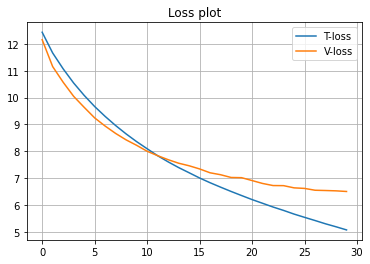

In [15]:
plt.figure()
plt.plot(epoch_loss, label='T-loss')
plt.plot(epoch_vl, label='V-loss')
plt.title('Loss plot')
plt.grid()
plt.legend()
plt.show()

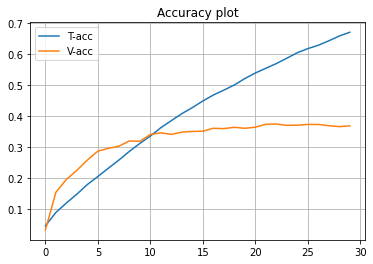

In [16]:
plt.figure()
plt.plot(epoch_acc, label='T-acc')
plt.plot(epoch_va, label='V-acc')
plt.title('Accuracy plot')
plt.grid()
plt.legend()
plt.show()